In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer

In [3]:
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [4]:
train_path = "/content/IMDB Dataset-1.csv"

In [5]:
# Trying to read the CSV file with different encodings
try:
    df = pd.read_csv(train_path, encoding='utf-8')
except UnicodeDecodeError:
    try:
        df = pd.read_csv(train_path, encoding='ISO-8859-1')
    except UnicodeDecodeError:
        df = pd.read_csv(train_path, encoding='cp1252')

In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


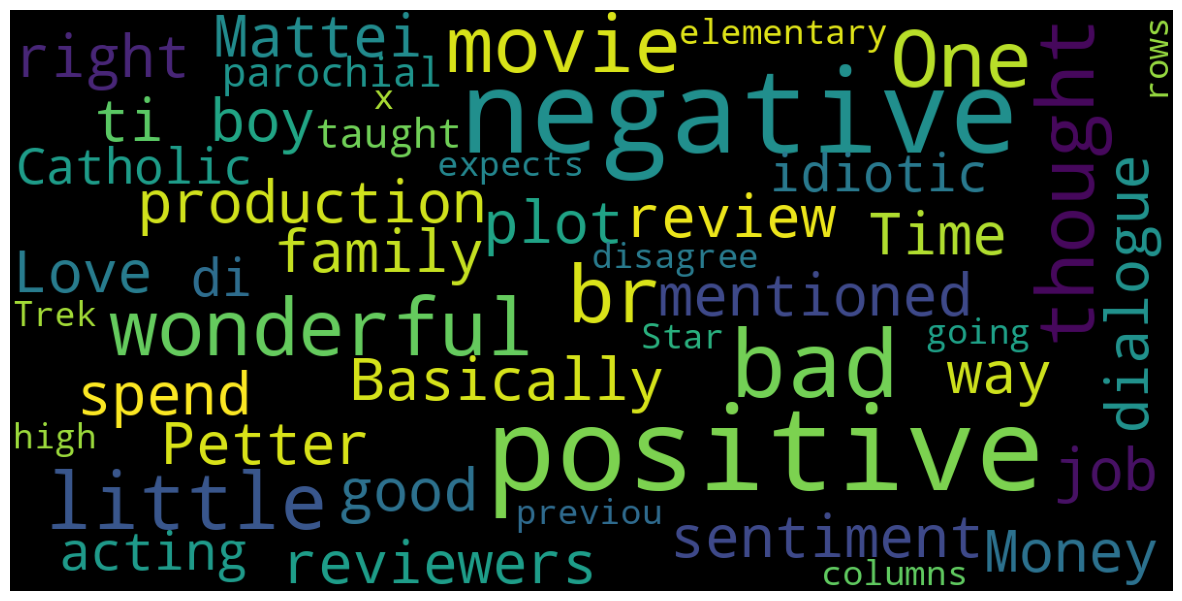

In [7]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color='black', stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df)

In [8]:
import nltk
nltk.download('stopwords')
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


# Function to clean a single review
def clean_review(review):
    # Remove HTML tags and line breaks
    cleaned_text = re.sub(r'<br\s*/*>', ' ', review)
    cleaned_text = re.sub(r'<[^>]*>', '', cleaned_text)

    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = re.findall(r'\b\w+\b', cleaned_text.lower())
    filtered_words = [word for word in words if word not in stop_words]

    # Apply Porter stemming
    porter = PorterStemmer()
    stemmed_words = [porter.stem(word) for word in filtered_words]

    # Join the stemmed words back into a cleaned text
    cleaned_text = ' '.join(stemmed_words)
    return cleaned_text

# Apply the cleaning function to the 'review' column
df['cleaned_review'] = df['review'].apply(clean_review)

# Print the cleaned dataset
print(df[['review', 'cleaned_review']])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                                  review  \
0      One of the other reviewers has mentioned that ...   
1      A wonderful little production. <br /><br />The...   
2      I thought this was a wonderful way to spend ti...   
3      Basically there's a family where a little boy ...   
4      Petter Mattei's "Love in the Time of Money" is...   
...                                                  ...   
49995  I thought this movie did a down right good job...   
49996  Bad plot, bad dialogue, bad acting, idiotic di...   
49997  I am a Catholic taught in parochial elementary...   
49998  I'm going to have to disagree with the previou...   
49999  No one expects the Star Trek movies to be high...   

                                          cleaned_review  
0      one review mention watch 1 oz episod hook righ...  
1      wonder littl product film techniqu unassum old...  
2      thought wonder way spend time hot summer weeke...  
3      basic famili littl boy jake think zo

In [9]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df,test_size =0.10,random_state=42)

In [10]:
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one review mention watch 1 oz episod hook righ...
1,A wonderful little production. <br /><br />The...,positive,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,positive,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,negative,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visual stun film...


In [11]:
train_x, train_y = train['cleaned_review'], train['sentiment']
test_x, test_y = test['cleaned_review'], test['sentiment']

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2))  # Adjusting the n-gram range as needed
X_train_vectorized = vectorizer.fit_transform(train_x)
X_test_vectorized = vectorizer.transform(test_x)

In [13]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(stop_words='english')
# train_x_vector = tfidf.fit_transform(train_x)
# # also fit the test_x_vector
# test_x_vector = tfidf.transform(test_x)

In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(X_train_vectorized, train_y)

In [ ]:
print(svc.predict(tfidf.transform(['A good movie'])))
print(svc.predict(tfidf.transform(['An excellent movie'])))
print(svc.predict(tfidf.transform(['it was a fine movie, not that great'])))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()
dec_tree.fit(train_x_vector, train_y)

DecisionTreeClassifier()

In [ ]:
print(dec_tree.predict(tfidf.transform(['A good movie'])))
print(dec_tree.predict(tfidf.transform(['An excellent movie'])))
print(dec_tree.predict(tfidf.transform(['it was a fine movie, not that great'])))

['positive']
['positive']
['positive']


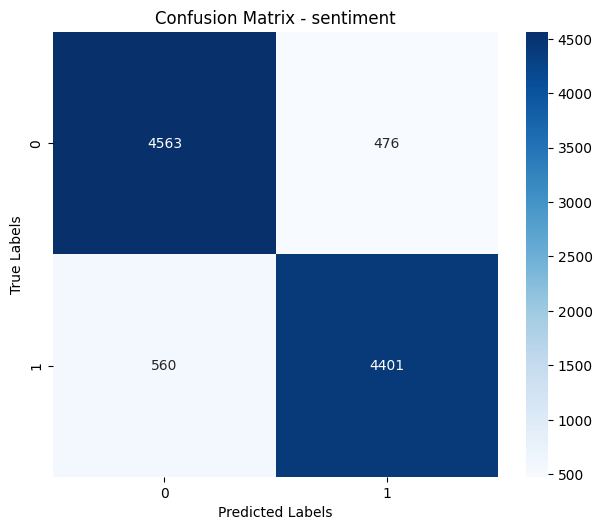

              precision    recall  f1-score   support

    positive       0.89      0.91      0.90      5039
    negative       0.90      0.89      0.89      4961

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
# Printing the confusion matrix
conf_matrix = multilabel_confusion_matrix(test_y, svc.predict(test_x_vector))
plt.figure(figsize=(12, 10))
for i, label in enumerate(train.columns[1:]):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {label}')

    plt.tight_layout()
    plt.show()

    print(classification_report(test_y, svc.predict(test_x_vector), labels = ['positive','negative']))

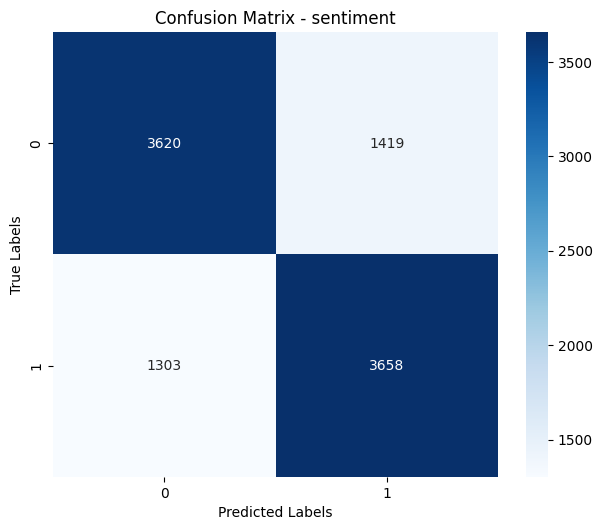

              precision    recall  f1-score   support

    positive       0.74      0.72      0.73      5039
    negative       0.72      0.74      0.73      4961

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



In [ ]:
# Printing the confusion matrix
conf_matrix = multilabel_confusion_matrix(test_y, dec_tree.predict(test_x_vector))
plt.figure(figsize=(12, 10))
for i, label in enumerate(train.columns[1:]):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {label}')

    plt.tight_layout()
    plt.show()

    print(classification_report(test_y, dec_tree.predict(test_x_vector), labels = ['positive','negative']))